1. Import necessary libraries and PORT-EK source code:

In [1]:
import os
import sys
import json
import pathlib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True
print(os.getpid())

4099200


2. Declare data set specific definitions and functions:

In [2]:
# PORT-EK parameters
k = 11 # This is the length of k-mers
c = 0.05  # This is the conservation thershold used in k-mer rarity filter
m = 1  # This is the maximum number of mismatches allowed when re-examining rare k-mers
min_RMSE = 0.1  # This is the RMSE threshold used to select enriched k-mers
m_map = 2  # This is the maximum number of mismatches allowed when mapping k-mers to reference genome
l_map = 1000  # This the maximum allowed offset of mapping position from average position of k-mer in samples

# Relative path to k-mer indices
INPUT_PATH = "../output/HIV/scenario1"

# Data set specific definitions of k-mer type, column names, reference gene and protein mapping, and colors for plots.
FREQ_COLS = ["M_freq", "nonM_freq"]
AVG_COLS = ["M_avg", "nonM_avg"]

VOLCANO_CMAP = {
    "not significant": ("#DDDDDD", 0.5),
    "M over-represented": ("#ffa401", 1),
    "nonM over-represented": ("#005ff5", 1),
}


def encode_kmer(kmer_seq: str) -> int:
    encoding_dict = {"A":"00","C":"01","G":"10","T":"11"}
    kmer_bin_string = [encoding_dict[nuc] for nuc in kmer_seq]
    id = int("".join(kmer_bin_string), base=2)
    return id


def decode_kmer(id: int, k) -> str:
    decoding = {"00":"A", "01":"C","10":"G","11":"T"}
    kmer_bin_string = bin(id)[2:].rjust(2*k, "0")
    kmer_bin_string = [kmer_bin_string[i:i+2] for i in range(0, len(kmer_bin_string),2)]
    kmer_seq = "".join([decoding[bits] for bits in kmer_bin_string])
    
    return kmer_seq


def assign_kmer_type(row):
    if (
        row["M_err"] > 0
        and row["p-value"] < 0.01
    ):
        return "M over-represented"
    elif (
        row["M_err"] < 0
        and row["p-value"] < 0.01
    ):
        return "nonM over-represented"
    else:
        return "not significant"

3. Construct k-mer count matrix and apply rarity filter

In [3]:
# First read all sample labels and k-mer sequences and construct an empty matrix. It requires significantly less memory than growing the matrix one-by-one.
kmer_set = set()
sample_list = []
kmer_set_in_path = pathlib.Path(INPUT_PATH).glob(f"*{k}mer_set.pkl")
sample_list_in_path = pathlib.Path(INPUT_PATH).glob("*sample_list.pkl")

for filename in kmer_set_in_path:
    with open(filename, mode="rb") as in_file:
        partial_set = pickle.load(in_file)
    kmer_set.update(partial_set)

for filename in sample_list_in_path:
    with open(filename, mode="rb") as in_file:
        partial_list = pickle.load(in_file)
    group = filename.stem.split("_")[0]
    partial_list = [f"{group}_{sample_name}" for sample_name in partial_list]
    sample_list.extend(partial_list)

all_kmer_matrix = pd.DataFrame(
    0, index=list(kmer_set), columns=sample_list, dtype="uint8"
)
M_sample_idx = [sample for sample in all_kmer_matrix.columns if sample[0] == "M"]
nonM_sample_idx = [
    sample for sample in all_kmer_matrix.columns if "nonM" in sample[0:4] == "nonM"
]

print(f"\nImported {len(kmer_set)} kmers and {len(sample_list)} samples.")

# Next, fill the table with k-mer counts.
counter = 1
tot_files = len(sample_list)
in_path = pathlib.Path(f"{INPUT_PATH}/{k}mer_indices").glob("*_count.pkl")

for filename in in_path:
    with open(filename, mode="rb") as in_file:
        temp_dict = pickle.load(in_file)
    sample_name = "_".join(filename.stem.split("_")[:-1])
    count_dict = {f"{sample_name}": temp_dict.values()}
    temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
    all_kmer_matrix.update(temp_df)
    print(
        f"Completed {filename.stem}. {counter} of {tot_files} indices done.",
        end="\r",
        flush=True,
    )
    counter += 1

# Decode k-mer sequences
all_kmer_matrix.index = all_kmer_matrix.index.map(lambda id: decode_kmer(id,k))

# Construct a temporary binary count matrix, i.e. one that shows if a k-mer is present in sequence, without regards to actual count.
# Calculate k-mer frequencies and average counts in host groups.
# for idx, column in enumerate(FREQ_COLS):
#     seq_list = list(SeqIO.parse(IN_FASTAS[idx], format="fasta"))
#     for kmer in all_kmer_matrix.index:
#         counter = 0
#         for seq in seq_list:
#             if kmer in seq.seq:
#                 counter += 1
#         all_kmer_matrix.loc[kmer, column] = counter/len(seq_list)
bin_kmer_matrix = all_kmer_matrix > 0
all_kmer_matrix["M_freq"] = bin_kmer_matrix.loc[:, M_sample_idx].mean(axis=1)
all_kmer_matrix["nonM_freq"] = bin_kmer_matrix.loc[:, nonM_sample_idx].mean(axis=1)

all_kmer_matrix["M_avg"] = all_kmer_matrix.loc[:, M_sample_idx].mean(axis=1)
all_kmer_matrix["nonM_avg"] = all_kmer_matrix.loc[:, nonM_sample_idx].mean(axis=1)

# del bin_kmer_matrix

# Remove polyA, as its presence and count is mostly dependant on sequencing quality not viral variant.
if 0 in all_kmer_matrix.index:
    all_kmer_matrix = all_kmer_matrix.drop(0)

# Apply rarity filter.
common_kmer_matrix = portek.filter_kmers(
    all_kmer_matrix, freq_cols=FREQ_COLS, cons_thr=c
)

print(
    f"\n{len(common_kmer_matrix)} common k-mers remaining after filtering at a threshold of {c}."
)


Imported 1240578 kmers and 15295 samples.
Completed M_B.US.2021.PID3FD-Pl5-K12-R.OQ948688_count. 15295 of 15295 indices done..ces done..5 indices done.e.ne.
62296 common k-mers remaining after filtering at a threshold of 0.05.


4. Calculate common k-mer statistics and identify host over-represented k-mers.

In [4]:
# Calculate mean k-mer count change, RMSE and test statistical significance.
common_kmer_matrix["M_err"] = (
    common_kmer_matrix["M_avg"] - common_kmer_matrix["nonM_avg"]
)
common_kmer_matrix["M_RMSE"] = np.sqrt((common_kmer_matrix["M_err"]) ** 2)
common_kmer_matrix["seq"] = common_kmer_matrix.index
common_kmer_matrix["p-value"] = common_kmer_matrix["seq"].apply(
    portek.calc_kmer_pvalue,
    args=(M_sample_idx, nonM_sample_idx, common_kmer_matrix),
)
common_kmer_matrix = common_kmer_matrix.sort_values("M_RMSE", ascending=False)
common_kmer_matrix = common_kmer_matrix.drop("seq", axis=1)
common_kmer_matrix["-log10_p-value"] = -np.log10(
    common_kmer_matrix["p-value"]
)

# Identify host-overrepresented k-mers, according to the statistics calculated above.
common_kmer_matrix["group"] = common_kmer_matrix.apply(assign_kmer_type, axis=1)

# Make a separate DataFrame with just the statistics, without counts, for export and analysis.
common_kmer_stat_matrix = common_kmer_matrix.drop(sample_list, axis=1)

# Record over-represented k-mers in separate DataFrames
M_overrep = common_kmer_matrix[
    common_kmer_matrix["group"] == "M over-represented"
]
nonM_overrep = common_kmer_matrix[
    common_kmer_matrix["group"] == "nonM over-represented"
]

Optional: save/load k-mer count and statistics matrices. Uncomment the relevant lines to save/load particular files.

In [5]:
# common_kmer_matrix.to_csv(f"../output/HIV/scenario1/common_{k}mer_count_matrix.csv")
common_kmer_stat_matrix.to_csv(f"../output/HIV/scenario1/common_{k}mer_stat_matrix.csv")
# all_kmer_matrix.to_csv(f"../output/HIV/scenario1/all_{k}mer_count_matrix.csv")

# common_kmer_matrix = pd.read_csv(f"../output/HIV/scenario1/common_{k}mer_count_matrix.csv", index_col=0)
# all_kmer_matrix = pd.read_csv(f"../output/HIV/scenario1/common_{k}mer_stat_matrix2.csv", index_col=0)
# common_kmer_stat_matrix = pd.read_csv(f"../output/HIV/scenario1/all_{k}mer_count_matrix.csv", index_col=0)

5. Visualize common k-mers using volcano plots. Uncomment the last line in each cell to save as svg.

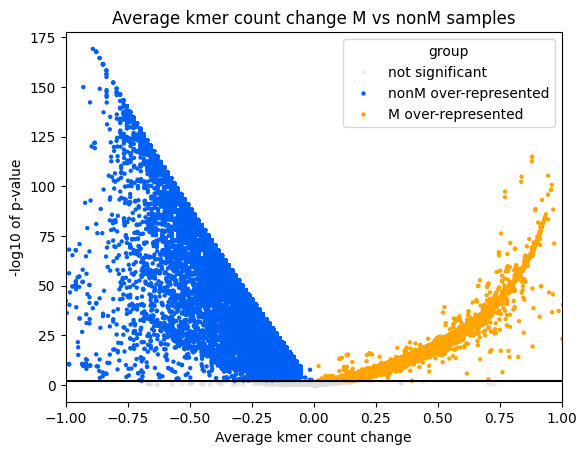

In [6]:
fig, ax = plt.subplots()
plt.axhline(y=-np.log10(0.01), color = 'black')
ax.set_xlim(-1,1)
ax.set_title('Average kmer count change M vs nonM samples')
ax.set_xlabel('Average kmer count change')
ax.set_ylabel('-log10 of p-value')
sns.scatterplot(data=common_kmer_matrix, x='M_err', y = '-log10_p-value', s=10, linewidth = 0, hue='group', palette=VOLCANO_CMAP)
plt.show()

# plt.savefig("../output/deer/deer_15mers_change_vs_p_early.svg", dpi = 600, format = "svg")

6. Optionally re-examin rare k-mers similar to over-represented k-mers. Run the two cells below only if you want to include potential rare, but still enriched k-mers in the analysis.

In [7]:
# Select all rare k-mers that have higher average count in M, no matter the statistical significance.
M_overrep_rare = all_kmer_matrix.loc[
    (all_kmer_matrix["M_avg"] == all_kmer_matrix[AVG_COLS].max(axis=1))
]
M_overrep_rare = M_overrep_rare[~M_overrep_rare.index.isin(M_overrep.index)]

# Comment the following line to avoid lengthy k-mer similarity graph calculation
M_overrep_similarity_graph = portek.build_similarity_graph_two_list(
    M_overrep.index.tolist(), M_overrep_rare.index.tolist(), m
)

# Uncomment the first of the following blocks to save the graph as pickle file. Uncomment the second to load a previously calculated graph.

# with open(f"../output/HIV/scenario1/mor_{k}mer_{m}m.pickle", mode = "wb") as out_file:
#     pickle.dump(deer_overrep_similarity_graph, out_file)

# with open(f"../output/HIV/scenario1/mor_{k}mer_{m}m.pickle", mode = "rb") as in_file:
#     deer_overrep_similarity_graph = pickle.load(in_file)

# Discard rare k-mers that are not in the similarity graph.
M_overrep_rare = M_overrep_rare[
    M_overrep_rare.index.isin(M_overrep_similarity_graph.nodes)
]

# Calculate statistics and significance for rare k-mers similar to bat over-represented k-mers and choose the significant ones.
# Calculation is identical to the one done for common k-mers.
M_overrep_rare["M_err"] = M_overrep_rare["M_avg"] - M_overrep_rare["nonM_avg"]
M_overrep_rare["M_RMSE"] = np.sqrt(((M_overrep_rare["M_err"]) ** 2))
M_overrep_rare["seq"] = M_overrep_rare.index
M_overrep_rare["p-value"] = M_overrep_rare["seq"].apply(
    portek.calc_kmer_pvalue,
    args=(M_sample_idx, nonM_sample_idx, M_overrep_rare),
)

M_overrep_rare = M_overrep_rare.sort_values("M_RMSE", ascending=False)
M_overrep_rare = M_overrep_rare.drop("seq", axis=1)
M_overrep_rare["-log10_p-value"] = -np.log10(M_overrep_rare["p-value"])
M_overrep_rare["group"] = M_overrep_rare.apply(assign_kmer_type, axis=1)
M_overrep_rare = M_overrep_rare[M_overrep_rare["group"] == "M over-represented"]
M_overrep_all = pd.concat([M_overrep_rare, M_overrep])

KeyboardInterrupt: 

In [ ]:
# See cell above for explanation. This cell has the same calculations, but done on nonM over-represented k-mers.
nonM_overrep_rare = all_kmer_matrix.loc[
    (all_kmer_matrix["M_avg"] == all_kmer_matrix[AVG_COLS].min(axis=1))
]
nonM_overrep_rare = nonM_overrep_rare[~nonM_overrep_rare.index.isin(nonM_overrep.index)]

# Comment the following line to avoid lengthy k-mer similarity graph calculation
nonM_overrep_similarity_graph = portek.build_similarity_graph_two_list(
    nonM_overrep.index.tolist(), nonM_overrep_rare.index.tolist(), m
)

# Uncomment the first of the following blocks to save the graph as pickle file. Uncomment the second to load a previously calculated graph.

# with open(f"../output/HIV/scenario1/nonmor_{k}mer_{m}m.pickle", mode = "wb") as out_file:
#     pickle.dump(nonM_overrep_similarity_graph, out_file)

# with open(f"../output/HIV/scenario1/nonmor_{k}mer_{m}m.pickle", mode = "rb") as in_file:
#     nonM_overrep_similarity_graph = pickle.load(in_file)

nonM_overrep_rare = nonM_overrep_rare[
    nonM_overrep_rare.index.isin(nonM_overrep_similarity_graph.nodes)
]

nonM_overrep_rare["M_err"] = nonM_overrep_rare["M_avg"] - nonM_overrep_rare["nonM_avg"]
nonM_overrep_rare["M_RMSE"] = np.sqrt(((nonM_overrep_rare["M_err"]) ** 2))
nonM_overrep_rare["seq"] = nonM_overrep_rare.index
nonM_overrep_rare["p-value"] = nonM_overrep_rare["seq"].apply(
    portek.calc_kmer_pvalue,
    args=(M_sample_idx, nonM_sample_idx, nonM_overrep_rare),
)

nonM_overrep_rare = nonM_overrep_rare.sort_values("M_RMSE", ascending=False)
nonM_overrep_rare = nonM_overrep_rare.drop("seq", axis=1)
nonM_overrep_rare["-log10_p-value"] = -np.log10(nonM_overrep_rare["p-value"])

nonM_overrep_rare["group"] = nonM_overrep_rare.apply(assign_kmer_type, axis=1)
nonM_overrep_rare = nonM_overrep_rare[
    nonM_overrep_rare["group"] == "nonM over-represented"
]
nonM_overrep_all = pd.concat([nonM_overrep_rare, nonM_overrep])

7. Find enriched k-mers by applying the RMSE filter. Export enriched k-mers for use in host classification.

In [ ]:
# Take the over-represented k-mers that pass the RMSE filter. This generates of enriched k-mers identified by PORT-EK.

# Uncomment this block if you didn't re-examine the rare k-mers.
# M_enriched = M_overrep[M_overrep["M_RMSE"] > min_RMSE]
# non_M_enriched = non_M_overrep[non_M_overrep["M_RMSE"] > min_RMSE]

# Comment this block if you didn't re-examine the rare k-mers.
M_enriched = M_overrep_all[M_overrep_all['M_RMSE']>min_RMSE]
nonM_enriched = nonM_overrep_all[nonM_overrep_all['M_RMSE']>min_RMSE]

print(
    f"{len(M_enriched)} M enriched k-mers and {len(nonM_enriched)} non-M enriched k-mers found."
)


def assign_host_numerical(sample_id):
    if sample_id in M_sample_idx:
        host = 1
    else:
        host = 0
    return host


# Prepare and save count matrix with host labels for use by classifiers that predict the most probalbe host of a viral sequence.
counts_for_classifier = pd.concat([M_enriched, nonM_enriched]).T
counts_for_classifier.drop(common_kmer_stat_matrix.columns.difference(['group']), axis=0, inplace=True)
counts_for_classifier['host'] = counts_for_classifier.index.map(assign_host_numerical)

counts_for_classifier.to_csv(f"../output/HIV/scenario1/{k}mer_counts_for_classifier.csv")

14585 M enriched k-mers and 16874 non-M enriched k-mers found.


8. Map enriched k-mers to the reference genome and identify host-enriched mutations.

In [ ]:
# Only map those k-mers that are unique in all genomes in which they appear. This helps with propper mapping.
M_enriched_unique = M_enriched.loc[
    M_enriched.loc[:, sample_list].max(axis=1) <= 1
]
nonM_enriched_unique = nonM_enriched.loc[
    nonM_enriched.loc[:, sample_list].max(axis=1) <= 1
]
unique_kmer_matrix = (
    pd.concat(
        [M_enriched_unique, nonM_enriched_unique],
        keys=["M enriched", "nonM enriched"],
    )
    .reset_index(level=0)
    .rename(columns={"level_0": "type"})
)

# As viruses may contain some similar repeating sequences, ambiguous mappings are resolved using distance to mean k-mer position in sequences.
# This requires creating a k-mer position matrix from k-mer indices.
enriched_kmer_pos_matrix = pd.DataFrame(
    0, index=unique_kmer_matrix.index, columns=sample_list
)
enriched_kmer_pos_matrix.index = enriched_kmer_pos_matrix.index.map(encode_kmer)
in_path = pathlib.Path(f"{INPUT_PATH}/{k}mer_indices").glob("*_pos.pkl")
for filename in in_path:
    with open(filename, mode="rb") as in_file:
        temp_dict = pickle.load(in_file)
    sample_name = "_".join(filename.stem.split("_")[:-1])
    pos_dict = {f"{sample_name}": [pos[0] for pos in temp_dict.values()]}
    temp_df = pd.DataFrame(pos_dict, index=temp_dict.keys(), dtype="uint16")
    enriched_kmer_pos_matrix.update(temp_df)

enriched_kmer_pos_matrix.index = enriched_kmer_pos_matrix.index.map(lambda id: decode_kmer(id,k))
# Uncomment the code below to save/load the position matrix to avoid multiple calculations.
# enriched_kmer_pos_matrix.to_csv("../output/deer/enriched_15mer_pos_matrix.csv")
# enriched_kmer_pos_matrix = pd.read_csv("../output/deer/enriched_15mer_pos_matrix.csv", index_col=0)

In [ ]:
# Define reference viral sequence. The default is SARS-CoV-2 isolate Wuhan-Hu-1, GenBank accesion number MN908947.3.
ref_seq = SeqIO.read("../input/HXB2.fasta", format="fasta")
ref_seq_str = str(ref_seq.seq)
ref_len = len(ref_seq.seq)

# Prepare DataFrames and dictionaries that will hold k-mer mappings, mutations and k-mer coverage of reference sequence.
kmer_coverage_n = pd.DataFrame(
    0, index=range(1, len(ref_seq) + 1), columns=["n_M_enriched", "n_nonM_enriched"]
)
kmer_coverage_kmer = pd.DataFrame(
    [[[], []] for _ in range(1, len(ref_seq) + 1)],
    index=range(1, len(ref_seq) + 1),
    columns=["M_enriched", "nonM_enriched"],
    dtype="object",
)
kmer_coverage = pd.concat([kmer_coverage_n, kmer_coverage_kmer], axis=1)
non_zero_pos_matrix = enriched_kmer_pos_matrix[enriched_kmer_pos_matrix > 0]

kmer_align_dict = {"seq": [], "type": [], "start": [], "n_match": []}
mut_dict = {"id": [], "type": [], "ref_nt": [], "ref_pos": [], "mut_nt": [], "kmer": []}

# Map each k-mer and find mutations.
for i, kmer in enumerate(unique_kmer_matrix.index):
    alignment, mutations = portek.map_kmers_find_mutations(
        kmer, ref_seq_str, non_zero_pos_matrix, m_map, l_map
    )

    if alignment != None:
        kmer_align_dict["seq"].append(alignment["seq"])
        if unique_kmer_matrix.loc[kmer, "type"] == "M enriched":
            kmer_align_dict["type"].append("M enriched")
            mut_dict["type"].extend(["M enriched"] * len(mutations["id"]))
            kmer_coverage.loc[
                alignment["start"] : alignment["start"] + 14, "n_M_enriched"
            ] += 1
            kmer_coverage.loc[
                alignment["start"] : alignment["start"] + 14, "M_enriched"
            ].apply(lambda element: element.append(kmer))
        else:
            kmer_align_dict["type"].append("nonM enriched")
            mut_dict["type"].extend(["nonM enriched"] * len(mutations["id"]))
            kmer_coverage.loc[
                alignment["start"] : alignment["start"] + 14, "n_nonM_enriched"
            ] += 1
            kmer_coverage.loc[
                alignment["start"] : alignment["start"] + 14, "nonM_enriched"
            ].apply(lambda element: element.append(kmer))

        kmer_align_dict["start"].append(alignment["start"])
        kmer_align_dict["n_match"].append(alignment["n_match"])

        mut_dict["id"].extend(mutations["id"])
        mut_dict["ref_nt"].extend(mutations["ref_nt"])
        mut_dict["ref_pos"].extend(mutations["pos"])
        mut_dict["mut_nt"].extend(mutations["mut_nt"])
        mut_dict["kmer"].extend(mutations["kmer"])

# Save mappings and mutations as DataFrames.
enriched_kmer_mappings = (
    pd.DataFrame(kmer_align_dict).sort_values("start").set_index("seq")
)
mutations = pd.DataFrame(mut_dict).set_index("id")
mutations = (
    mutations.groupby("id")
    .agg(
        {
            "type": "first",
            "ref_nt": "first",
            "ref_pos": "first",
            "mut_nt": "first",
            "kmer": lambda x: list(x),
        }
    )
    .sort_values("ref_pos")
)

print(
    f"{len(enriched_kmer_mappings)} kmers of {len(unique_kmer_matrix)} mapped to reference genome."
)

# Assign mappings and mutations to gene and protein coding regions.
# Discard mutations with less than 9 (k-2) k-mers carrying it.
# Calculate max_RMSE of k-mers carrying the mutations and the frequency of mutations among hosts.
mutations["n_kmers"] = mutations["kmer"].apply(len)
mutations = mutations[mutations["n_kmers"] >= 9]
mutations["max_RMSE"] = mutations["kmer"].apply(
    lambda kmer_list: unique_kmer_matrix.loc[kmer_list, "M_RMSE"].max()
)
mutations["M_agg_mutation_freq"] = mutations["kmer"].apply(
    portek.calc_agg_freq, args=(M_sample_idx, unique_kmer_matrix)
)
mutations["nonM_agg_mutation_freq"] = mutations["kmer"].apply(
    portek.calc_agg_freq, args=(nonM_sample_idx, unique_kmer_matrix)
)

mutations = mutations.sort_values("ref_pos")

M_mutation_coverage = mutations[mutations["type"] == "M enriched"][
    "ref_pos"
].value_counts()
nonM_mutation_coverage = mutations[mutations["type"] == "nonM enriched"][
    "ref_pos"
].value_counts()
M_mutation_coverage.name = "n_M_mut"
nonM_mutation_coverage.name = "n_human_mut"
mutation_coverage = pd.concat(
    [M_mutation_coverage, nonM_mutation_coverage], axis=1
).fillna(0)
mutation_coverage["M_mut_freq_in_M"] = (
    mutations[mutations["type"] == "M enriched"]
    .groupby("ref_pos")
    .sum()["M_agg_mutation_freq"]
    .sort_values(ascending=False)
)
mutation_coverage["M_mut_freq_in_nonM"] = (
    mutations[mutations["type"] == "M enriched"]
    .groupby("ref_pos")
    .sum()["nonM_agg_mutation_freq"]
    .sort_values(ascending=False)
)

mutation_coverage["nonM_mut_freq_in_M"] = (
    mutations[mutations["type"] == "nonM enriched"]
    .groupby("ref_pos")
    .sum()["M_agg_mutation_freq"]
    .sort_values(ascending=False)
)
mutation_coverage["nonM_mut_freq_in_nonM"] = (
    mutations[mutations["type"] == "nonM enriched"]
    .groupby("ref_pos")
    .sum()["nonM_agg_mutation_freq"]
    .sort_values(ascending=False)
)

mutation_coverage.fillna(0, inplace=True)
mutation_coverage["pos"] = mutation_coverage.index

13735 kmers of 20229 mapped to reference genome.


In [ ]:
enriched_kmer_mappings

In [131]:
# Run this cell to save mapping and mutation output.
enriched_kmer_mappings.to_csv("../output/HIV/scenario1/enriched_9mer_mappings.csv")
kmer_coverage.to_csv("../output/HIV/scenario1/9mer_coverage.csv")
mutations.to_csv("../output/HIV/scenario1/group_associated_mutations.csv")
mutation_coverage.to_csv("../output/HIV/scenario1/group_associated_mutations_coverage.csv")

In [147]:
mutations.loc["T6977C"]

type                                                             M enriched
ref_nt                                                                    T
ref_pos                                                                6977
mut_nt                                                                    C
kmer                      [ACATGGAATCA, CACATGGAATC, CATGGTATCAG, CATGGC...
n_kmers                                                                  11
max_RMSE                                                           0.534049
M_agg_mutation_freq                                                0.073315
nonM_agg_mutation_freq                                             0.739726
Name: T6977C, dtype: object

In [151]:
enriched_kmer_mappings.loc[["ACATGGAATCA","ACATGGCATCA"]]

,type,start,n_match
seq,,,
ACATGGAATCA,M enriched,6968,10
ACATGGCATCA,nonM enriched,6968,9


In [157]:
all_kmer_matrix.loc[mutations.loc["T6977C","kmer"]].iloc[:,-4:]

,M_freq,nonM_freq,M_avg,nonM_avg
ACATGGAATCA,0.070621,0.000000,0.070621,0.000000
CACATGGAATC,0.070621,0.000000,0.070621,0.000000
CATGGTATCAG,0.000066,0.041096,0.000066,0.041096
CATGGCATCAG,0.000131,0.041096,0.000131,0.041096
GGTATCAGGCC,0.000066,0.027397,0.000066,0.027397
TGGTATCAGGC,0.000066,0.027397,0.000066,0.027397
GTATCAGGCCA,0.000066,0.027397,0.000066,0.027397
CACATGGCATC,0.000197,0.534247,0.000197,0.534247
ACATGGCATCA,0.000197,0.534247,0.000197,0.534247
CACATGGTATC,0.000066,0.136986,0.000066,0.136986


In [158]:
all_kmer_matrix.loc["ACATGGAATTA"]

nonM_O.CM.1994.BCF06.AB485666       0.000000
nonM_O.CM.1994.BCF06.AB485667       0.000000
nonM_O.US.-.I_2478B.AB485668        0.000000
nonM_O.US.-.I_2478B.AB485669        0.000000
nonM_O.FR.1992.VAU.AF407418         0.000000
                                      ...   
M_F2.CM.2011.11CMMDC224.MT349417    1.000000
M_freq                              0.801537
nonM_freq                           0.068493
M_avg                               0.801537
nonM_avg                            0.068493
Name: ACATGGAATTA, Length: 15299, dtype: float64

9. Plot k-mer coverage and mutation frequencies by position. Uncomment the last line in each cell to save the plot as svg.

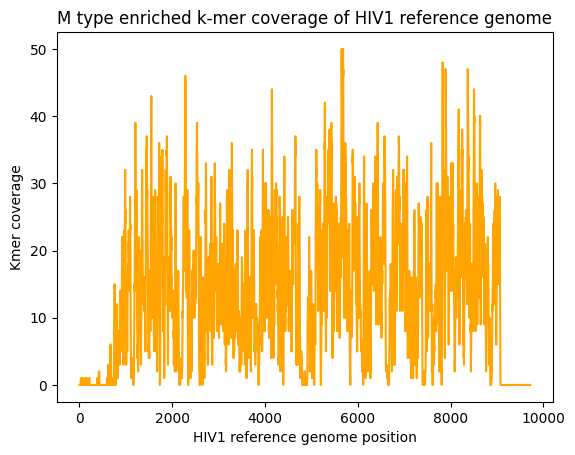

In [134]:
fig, ax = plt.subplots()
ax.set_title("M type enriched k-mer coverage of HIV1 reference genome")
ax.set_xlabel("HIV1 reference genome position")
ax.set_ylabel("Kmer coverage")
sns.lineplot(x=kmer_coverage.index, y=kmer_coverage["n_M_enriched"], color="#ffa401")
plt.show()

# plt.savefig("../output/deer/enr_deer_kmer_ref_coverage.svg", dpi = 600, format = "svg")

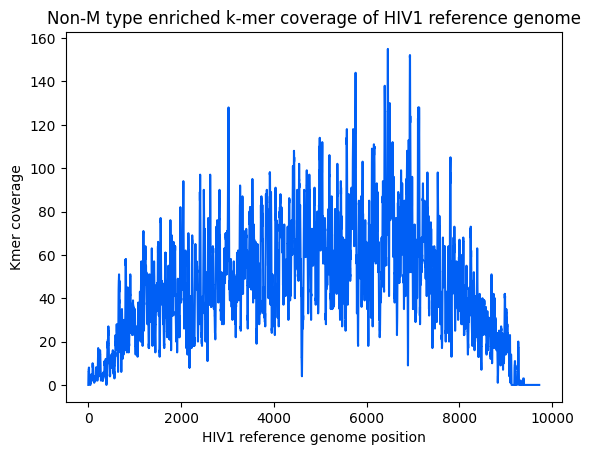

In [135]:
fig, ax = plt.subplots()
ax.set_title("Non-M type enriched k-mer coverage of HIV1 reference genome")
ax.set_xlabel("HIV1 reference genome position")
ax.set_ylabel("Kmer coverage")
sns.lineplot(
    x=kmer_coverage.index, y=kmer_coverage["n_nonM_enriched"], color="#005ff5"
)
plt.show()

# plt.savefig("../output/deer/enr_human_kmer_ref_coverage.svg", dpi = 600, format = "svg")

/tmp/ipykernel_3109475/3745220214.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


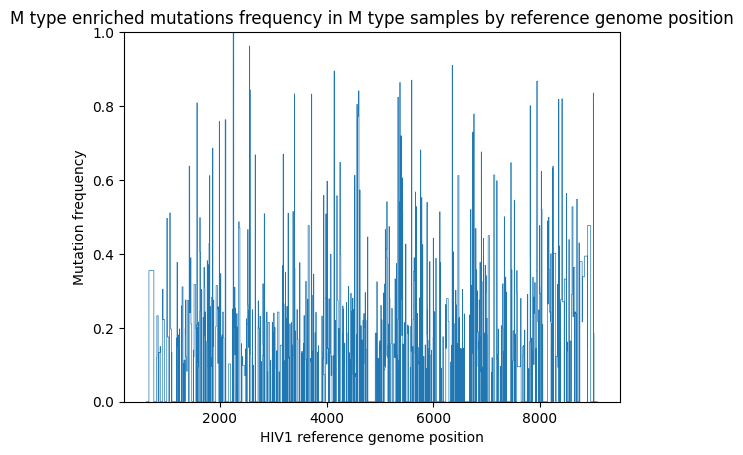

In [136]:
fig, ax = plt.subplots()
ax.set_title(
    "M type enriched mutations frequency in M type samples by reference genome position"
)
ax.set_xlabel("HIV1 reference genome position")
ax.set_ylabel("Mutation frequency")
ax.set_ylim(0, 1)
sns.lineplot(
    data=mutation_coverage,
    x=mutation_coverage.index,
    y="M_mut_freq_in_M",
    linewidth=0.5,
    palette="dark",
    drawstyle="steps",
)
plt.show()

# plt.savefig("../output/deer/enr_deer_mut_in_deer.svg", dpi = 600, format = "svg", bbox_inches='tight')

/tmp/ipykernel_3109475/4221503802.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


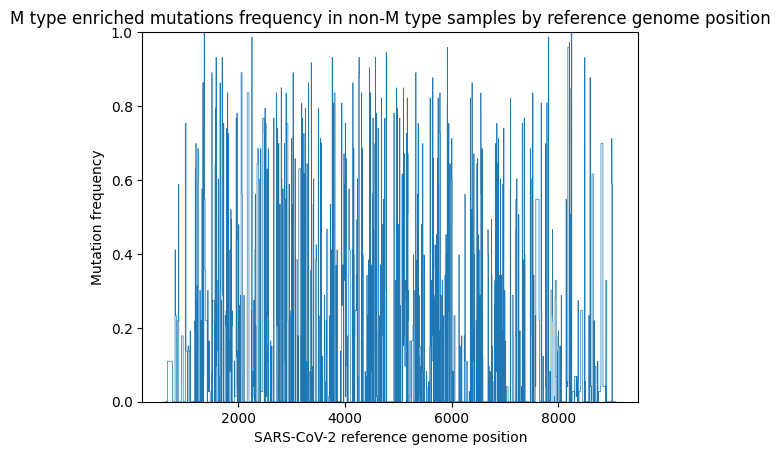

In [137]:
fig, ax = plt.subplots()
ax.set_title(
    "M type enriched mutations frequency in non-M type samples by reference genome position"
)
ax.set_xlabel("SARS-CoV-2 reference genome position")
ax.set_ylabel("Mutation frequency")
ax.set_ylim(0, 1)
sns.lineplot(
    data=mutation_coverage,
    x=mutation_coverage.index,
    y="M_mut_freq_in_nonM",
    linewidth=0.5,
    palette="dark",
    drawstyle="steps",
)
plt.show()

# plt.savefig("../output/deer/enr_deer_mut_in_humearly.svg", dpi = 600, format = "svg", bbox_inches='tight')

ValueError: Could not interpret value `deer_mut_freq_in_humlate` for `y`. An entry with this name does not appear in `data`.

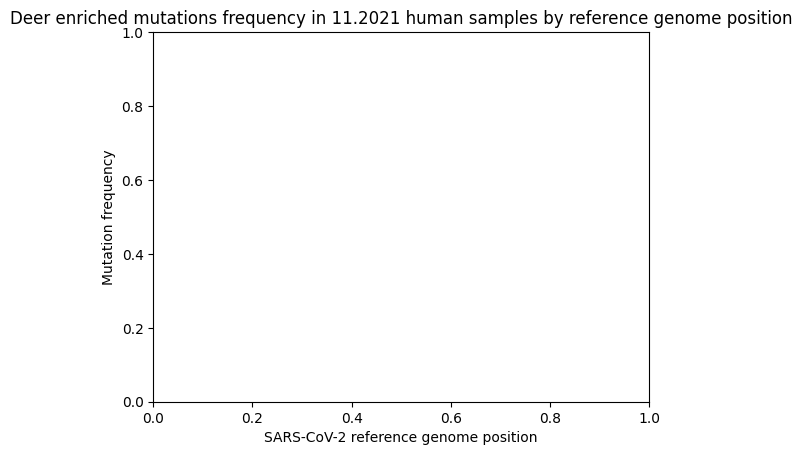

In [138]:
fig, ax = plt.subplots()
ax.set_title(
    "Deer enriched mutations frequency in 11.2021 human samples by reference genome position"
)
ax.set_xlabel("SARS-CoV-2 reference genome position")
ax.set_ylabel("Mutation frequency")
ax.set_ylim(0, 1)
sns.lineplot(
    data=mutation_coverage,
    x=mutation_coverage.index,
    y="deer_mut_freq_in_humlate",
    linewidth=0.5,
    hue="gene",
    palette="dark",
    drawstyle="steps",
)
plt.show()

# plt.savefig("../output/deer/enr_deer_mut_in_humlate.svg", dpi = 600, format = "svg", bbox_inches='tight')